# Conjugate Gradient Descent

In [2]:
import numpy as np
import plot as p
import cg
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example

Remember that CG is used to solve a linear function,

$$
Ax = b
$$

by instead minimizing,

$$
f(x) = \frac{1}{2} x^T A x - b^T x
$$

In [27]:
A = np.array([
    [1, 0],
    [0, 1],
])
b = np.array([
    [0],
    [0],
])

def _reshape_grid(x):
    return x.T[:,:,np.newaxis]
    
# x needs to be a list of column vectors
def f(x):
    if len(x.shape) == 2 and x.shape[0] == 2:
        x = _reshape_grid(x)
    
    assert len(x.shape) == 3
    dims = A.shape[0]
    assert x.shape[1:] == (dims, 1)
    xr = x
    xl = x.transpose((0, 2, 1))
    return (0.5 * np.matmul(xl, np.matmul(A, xr)) - np.matmul(b.T, xr)).flatten()

In [31]:
x0 = np.array([1, 0.3])
positions = cg.conjugate_gradient(A, b.flatten(), x0)

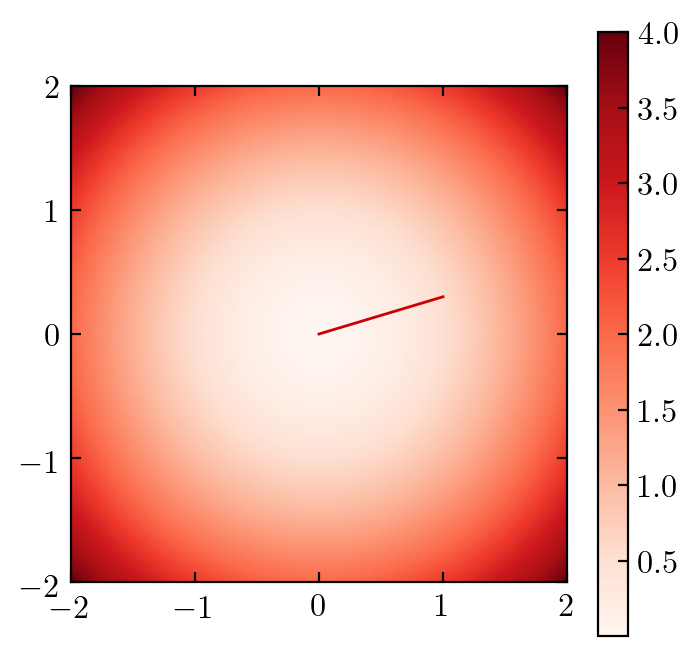

In [33]:
ax = p.plot_func(f, typ="image")
ax.plot(positions[:,0], positions[:,1])